In [1]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from os import (environ, path)
import sys

In [2]:
df = pd.read_csv(path.join(environ['DATA_FOLDER'],"train_sample.csv.zip"))

# Density

## Group by IP/Device/OS 

Again, if it's a public hotspot, we may see some spree behavior here. If the # of clicks from this triplet is low, but heavily concentrated ... might be some fraud.

In [3]:
df.click_time = pd.to_datetime(df.click_time)
df['time_diff_triplet'] = df.sort_values(['ip','device','os','click_time']).groupby(['ip','device','os'])['click_time'].diff()


In [4]:
def get_seconds(time_delta):
    return time_delta.seconds

df['seconds_triplet'] = df['time_diff_triplet'].apply(get_seconds)

### Sanity Check - do the seconds match the time_diff?

For this ip/device/os ... 8 hours between 1st and 2nd click, 3 hours between 2nd and 3rd click, and so on. 

In [5]:
df[(df.ip==118315) & (df.device==1) & (df.os==13)].sort_values(['click_time'])

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,time_diff_triplet,seconds_triplet
66615,118315,1,1,13,137,2017-11-07 08:36:03,NaN,0,NaT,NaN
28804,118315,3,1,13,280,2017-11-07 12:42:50,NaN,0,04:06:47,14807.0
62507,118315,18,1,13,134,2017-11-07 14:21:56,NaN,0,01:39:06,5946.0
36702,118315,3,1,13,489,2017-11-08 05:12:58,NaN,0,14:51:02,53462.0
64422,118315,6,1,13,459,2017-11-08 10:46:43,NaN,0,05:33:45,20025.0
66607,118315,15,1,13,245,2017-11-08 16:08:30,NaN,0,05:21:47,19307.0
89984,118315,11,1,13,137,2017-11-09 01:12:29,NaN,0,09:03:59,32639.0
68039,118315,2,1,13,237,2017-11-09 02:52:44,NaN,0,01:40:15,6015.0
18347,118315,2,1,13,237,2017-11-09 03:05:28,NaN,0,00:12:44,764.0
94144,118315,2,1,13,237,2017-11-09 05:21:52,NaN,0,02:16:24,8184.0


In [6]:
print(df.seconds_triplet.describe())
df.seconds_triplet.hist()

count    22384.000000
mean     28121.416011
std      24946.066455
min          0.000000
25%       6364.750000
50%      20706.500000
75%      45335.500000
max      86397.000000
Name: seconds_triplet, dtype: float64


    ### Wouldnt a robot user be fast?

For spree clicks, i would expect very little time between clicks. Let's filter seconds to < 1 minute and see how many < 1 minute lags there are for these triplets.

count    241.000000
mean      20.780083
std       17.829206
min        0.000000
25%        4.000000
50%       16.000000
75%       36.000000
max       59.000000
Name: seconds_triplet, dtype: float64


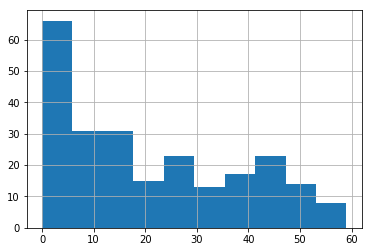

In [7]:
print(df[df.seconds_triplet < 60]['seconds_triplet'].describe())
df[df.seconds_triplet < 60]['seconds_triplet'].hist()

In [8]:
df[df.seconds_triplet<60].groupby(['ip','device','os']).size().sort_values(ascending=False)

ip      device  os
73487   1       19    6
5348    1       19    5
                13    5
5314    1       19    4
73516   1       13    3
                19    2
53454   1       19    2
17149   1       13    2
73487   1       13    2
5314    1       13    2
49602   1       19    2
60407   1       19    1
53790   1       1     1
57802   1       19    1
55477   1       19    1
53960   2       19    1
53806   1       19    1
61667   2       97    1
61691   1       13    1
57886   1       13    1
333539  1       41    1
53715   1       19    1
64172   1       13    1
53454   1       17    1
52695   1       41    1
52628   1       19    1
52024   1       19    1
50484   1       26    1
50213   1       23    1
49177   1       13    1
                     ..
83641   1       37    1
83391   1       19    1
100212  1       18    1
101863  1       19    1
119369  1       23    1
103026  1       22    1
119369  1       13    1
118315  1       15    1
118252  1       13    1
115744  1       22   

### 5314 - is the public hotspot

In [9]:
df[(df.seconds_triplet <60) & (df.ip == 5314)].sort_values(['click_time'])

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,time_diff_triplet,seconds_triplet
27333,5314,15,1,13,278,2017-11-07 01:57:42,NaN,0,00:00:45,45.0
5595,5314,25,1,13,259,2017-11-07 13:06:58,NaN,0,00:00:03,3.0
6273,5314,15,1,19,430,2017-11-07 13:40:51,NaN,0,00:00:18,18.0
90374,5314,3,1,19,205,2017-11-07 16:01:52,NaN,0,00:00:11,11.0
10261,5314,15,1,19,245,2017-11-08 00:54:13,NaN,0,00:00:22,22.0
39353,5314,2,1,19,219,2017-11-08 03:46:44,NaN,0,00:00:32,32.0


## Same analysis, Groupby IP (instead of triplets)

just to see the distribution. As expected, presumably the hotspots are at the top.

In [10]:
df['time_diff_ip'] = df.sort_values(['ip','click_time']).groupby(['ip'])['click_time'].diff()
df['seconds_ip'] = df['time_diff_ip'].apply(get_seconds)

count    887.000000
mean      27.040586
std       17.663667
min        0.000000
25%       12.000000
50%       26.000000
75%       42.000000
max       59.000000
Name: seconds_ip, dtype: float64


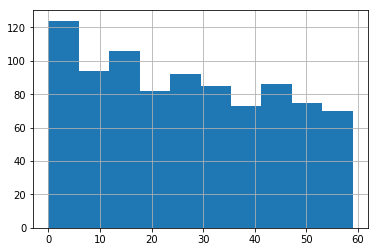

In [11]:
print(df[df.seconds_ip < 60]['seconds_ip'].describe())
df[df.seconds_ip < 60]['seconds_ip'].hist()

In [12]:
df[df.seconds_ip<60].groupby(['ip']).size().sort_values(ascending=False).to_frame('count') 

,count
ip,
5348,129
5314,107
73487,44
73516,43
53454,21
114276,14
100275,12
26995,11
95766,11


In [13]:
df[(df.seconds_ip <60) & (df.ip == 5348)].sort_values(['click_time']) # 5348 a hotspot?

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,time_diff_triplet,seconds_triplet,time_diff_ip,seconds_ip
69858,5348,15,1,27,245,2017-11-07 03:12:27,NaN,0,0 days 02:11:15,7875.0,00:00:33,33.0
39300,5348,18,1,19,107,2017-11-07 03:39:03,NaN,0,0 days 03:54:04,14044.0,00:00:05,5.0
94204,5348,1,2,13,125,2017-11-07 04:07:36,NaN,0,NaT,NaN,00:00:51,51.0
82894,5348,15,1,3,315,2017-11-07 04:14:49,NaN,0,0 days 00:19:48,1188.0,00:00:25,25.0
2999,5348,12,1,9,145,2017-11-07 04:49:47,NaN,0,0 days 05:15:15,18915.0,00:00:39,39.0
28477,5348,3,1,20,442,2017-11-07 05:41:12,NaN,0,NaT,NaN,00:00:21,21.0
94002,5348,3,1,35,442,2017-11-07 05:46:24,NaN,0,0 days 00:35:51,2151.0,00:00:15,15.0
76153,5348,3,1,18,280,2017-11-07 08:20:34,NaN,0,0 days 02:25:30,8730.0,00:00:33,33.0
25383,5348,3,1,17,452,2017-11-07 08:40:09,NaN,0,0 days 01:10:40,4240.0,00:00:29,29.0
51717,5348,18,1,15,121,2017-11-07 08:53:36,NaN,0,0 days 02:11:21,7881.0,00:00:56,56.0
